In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".9"

import matplotlib.pyplot as plt
import numpy as np

import jaxley as jx

import pandas as pd

from Allen_mech import * 

from neuron import h


from jaxley.modules import Branch, Cell, Compartment
from jaxley.utils.cell_utils import (
    _build_parents,
    _compute_pathlengths,
    _padded_radius_generating_fn,
    _radius_generating_fns,
    _split_into_branches_and_sort,
    build_radiuses_from_xyzr,
)

from typing import Callable, List, Optional, Tuple
from warnings import warn

import jax.numpy as jnp

from jaxley.utils.misc_utils import deprecated_kwargs

--No graphics will be displayed.


In [3]:
def build_radiuses_from_xyzr_varComps(
    radius_fns: List[Callable],
    branch_indices: List[int],
    min_radius: Optional[float],
    ncomp_list: List[int],
) -> jnp.ndarray:
    """Return the radiuses of branches given SWC file xyzr.

    Returns an array of shape `(num_branches, ncomp)`.

    Args:
        radius_fns: Functions which, given compartment locations return the radius.
        branch_indices: The indices of the branches for which to return the radiuses.
        min_radius: If passed, the radiuses are clipped to be at least as large.
        ncomp: The number of compartments that every branch is discretized into.
    """
    # Compartment locations are at the center of the internal nodes.
    radiuses = np.array([])
    for branch in branch_indices:
        ncomp = ncomp_list[branch]
        non_split = 1 / ncomp
        range_ = np.linspace(non_split / 2, 1 - non_split / 2, ncomp)
        radiuses = np.append(radiuses, radius_fns[branch](range_))
        if min_radius is None:
            assert np.all(
                radiuses > 0.0
            ), "Radius 0.0 in SWC file. Set `read_swc(..., min_radius=...)`."
        else:
            radiuses[radiuses < min_radius] = min_radius

    return radiuses

In [39]:
radiuses_each = build_radiuses_from_xyzr(
        radius_fns,
        range(len(parents)),
        min_radius,
        4,
    )

# returns an array of shape (# compartments) where each element is the radius of that compartment 

In [21]:
nseg_per_branch = 5
fname = '/Users/elena.westeinde/Code/jaxley_experiments/Allen_biophysical/Nr5a1_473862496/components/morphologies/reconstruction_noAxon.swc'
lcomp = 20 # from config file
max_branch_len = 20000
axon_ncomp = 2 # Allen biophysical model has 2 compartments for axon of 30 microns each

parents, pathlengths, radius_fns, types, coords_of_branches = jx.io.swc.swc_to_jaxley(
    fname, max_branch_len=max_branch_len, sort=True, num_lines=None
)
nbranches = len(parents)
comp = Compartment()
ncomp_list = []
lcomp_array = np.array([])
branch_list = []
for b in range(nbranches):
    b_length = pathlengths[b]
    if axon_ncomp is not None and types[b] == 2:
        ncomps = axon_ncomp
    else:
        ncomps = 1 + 2 * int(b_length/(2*lcomp))
    ncomp_list.append(ncomps)
    lcomp_array = np.append(lcomp_array, np.repeat(b_length, ncomps) / ncomps)
    branch = Branch([comp for _ in range(ncomps)])
    branch_list.append(branch)

# cell = Cell(
#         branch_list, parents=parents, xyzr=coords_of_branches
#     )

/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


In [4]:
def read_swc_varComps(
    fname: str,
    lcomp: Optional[int] = None,
    max_branch_len: Optional[float] = None,
    min_radius: Optional[float] = None,
    axon_ncomp: Optional[int] = None,
    assign_groups: bool = True
) -> Cell:
    """Reads SWC file into a `Cell`.

    Jaxley assumes cylindrical compartments and therefore defines length and radius
    for every compartment. The surface area is then 2*pi*r*length. For branches
    consisting of a single traced point we assume for them to have area 4*pi*r*r.
    Therefore, in these cases, we set lenght=2*r.

    Args:
        fname: Path to the swc file.
        lcomp: The desired compartment length, used to set number of compartments per branch.
        max_branch_len: If a branch is longer than this value it is split into two
            branches.
        min_radius: If the radius of a reconstruction is below this value it is clipped.
        assign_groups: If True, then the identity of reconstructed points in the SWC
            file will be used to generate groups `undefined`, `soma`, `axon`, `basal`,
            `apical`, `custom`. See here:
            http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html
        axon_ncomp: If passed, the number of compartments for axon branches.

    Returns:
        A `Cell` object.
    """

    parents, pathlengths, radius_fns, types, coords_of_branches = jx.io.swc.swc_to_jaxley(
        fname, max_branch_len=max_branch_len, sort=True, num_lines=None
    )
    nbranches = len(parents)
    comp = Compartment()
    ncomp_list = []
    lcomp_array = np.array([])
    branch_list = []
    for b in range(nbranches):
        b_length = pathlengths[b]
        if axon_ncomp is not None and types[b] == 2:
            ncomps = axon_ncomp
        else:
            ncomps = 1 + 2 * int(b_length/(2*lcomp))
        ncomp_list.append(ncomps)
        lcomp_array = np.append(lcomp_array, np.repeat(b_length, ncomps) / ncomps)
        branch = Branch([comp for _ in range(ncomps)])
        branch_list.append(branch)

    cell = Cell(
            branch_list, parents=parents, xyzr=coords_of_branches
        )

    # Also save the radius generating functions in case users post-hoc modify the number
    # of compartments with `.set_ncomp()`.
    cell._radius_generating_fns = radius_fns
    cell.set("length", lcomp_array)

    radiuses_each = build_radiuses_from_xyzr_varComps(
            radius_fns,
            range(len(parents)),
            min_radius,
            ncomp_list,
        )
    cell.set("radius", radiuses_each)

    # Description of SWC file format:
    # http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html
    ind_name_lookup = {
        0: "undefined",
        1: "soma",
        2: "axon",
        3: "basal",
        4: "apical",
        5: "custom",
    }

    types = np.asarray(types).astype(int)
    if assign_groups:
        for type_ind in np.unique(types):
            if type_ind < 5.5:
                name = ind_name_lookup[type_ind]
            else:
                name = f"custom{type_ind}"
            indices = np.where(types == type_ind)[0].tolist()
            if len(indices) > 0:
                cell.branch(indices).add_to_group(name)

    return cell 


/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(
/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


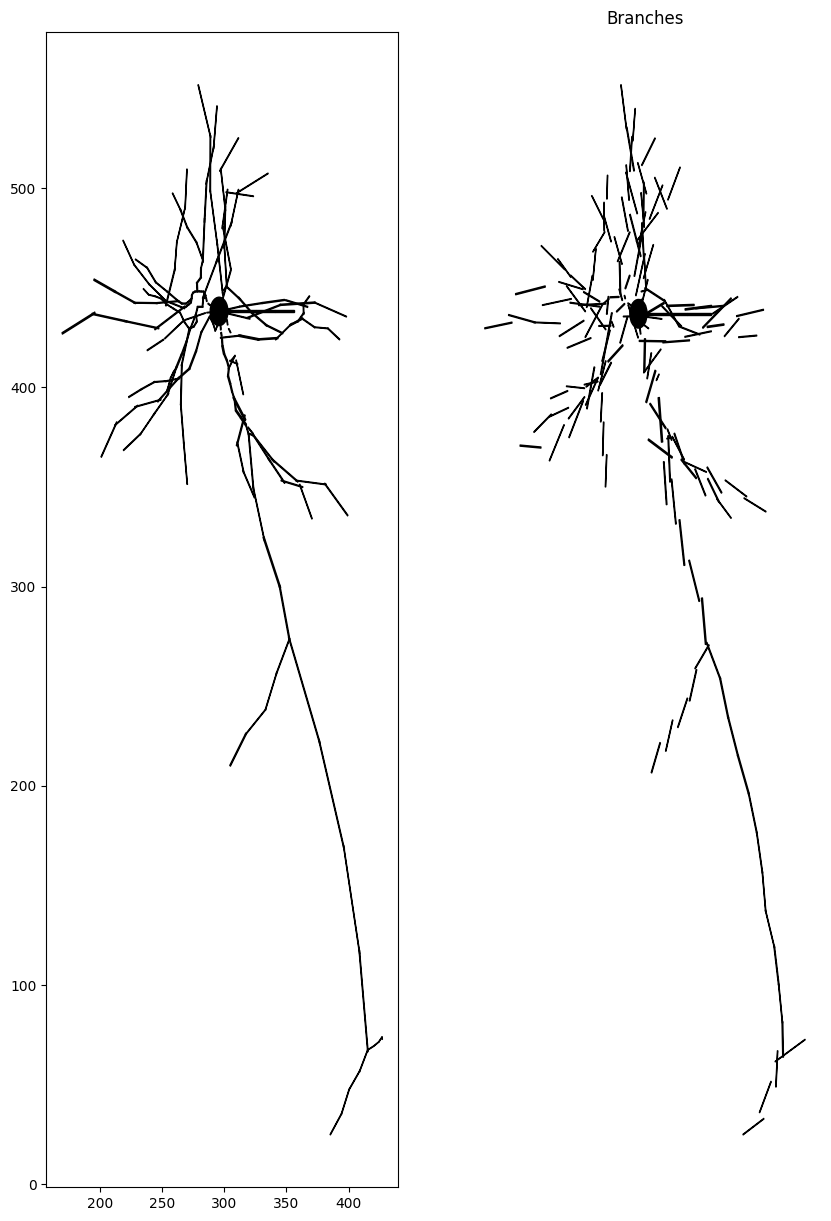

In [145]:
nseg_per_branch = 4
fname = '/Users/elena.westeinde/Code/jaxley_experiments/Allen_biophysical/Nr5a1_473862496/components/morphologies/reconstruction_noAxon.swc'
lcomp = 20 # from config file
max_branch_len = 2000
axon_ncomp = 2 # Allen biophysical model has 2 compartments for axon of 30 microns each

cell_orig = jx.read_swc(fname, nseg_per_branch, max_branch_len=2000.0, assign_groups=True)
cell = read_swc_varComps(fname, lcomp, max_branch_len=2000.0, axon_ncomp=None, assign_groups=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 15))
cell_orig.vis(ax=ax[0], type="comp")
cell.vis(ax=ax[1], type="comp")
# define colorwheel with 10 colors
# colors = plt.cm.tab10.colors
# for i, branch in enumerate(cell.branches):
#     branch.vis(ax=ax, col=colors[i % 10])
#cell.basal.vis(ax=ax, col='k')
plt.axis("off")
plt.title("Branches")
plt.show()

In [146]:
# nseg_per_branch = 1
# cell_orig = jx.read_swc(fname, nseg_per_branch, max_branch_len=2000.0, assign_groups=True)
# cell = cell_orig.copy()
# lcomp = 20
# soma_branch_idx = cell.soma.nodes['local_branch_index'].index.to_list()[0]
# for b in range(max(cell.nodes['local_branch_index'])+1):
#     branch_idx = cell.branch(b).nodes['local_branch_index'].index.to_list()[0]
#     if branch_idx != soma_branch_idx:
#         length = cell.branch(b).nodes['length'].iloc[0]
#         ncomp = 1 + 2 * int(length/(2*lcomp))
#         cell.branch(b).set_ncomp(ncomp)




# cell.nodes

cell.ncomp_per_branch

array([ 1,  3,  1,  1,  1,  1,  5,  1,  3,  5,  3,  3,  1,  5,  3,  1,  1,
        1,  1,  3,  1,  5,  1,  1,  5,  1,  5,  1,  1,  1,  1,  3,  3,  5,
        3,  3,  5,  1,  3,  1,  3,  3,  1,  5,  1, 11,  5,  3,  1,  5,  5,
        1,  3,  1,  5,  1,  3,  5])

In [150]:
print(cell.ncomp)

11


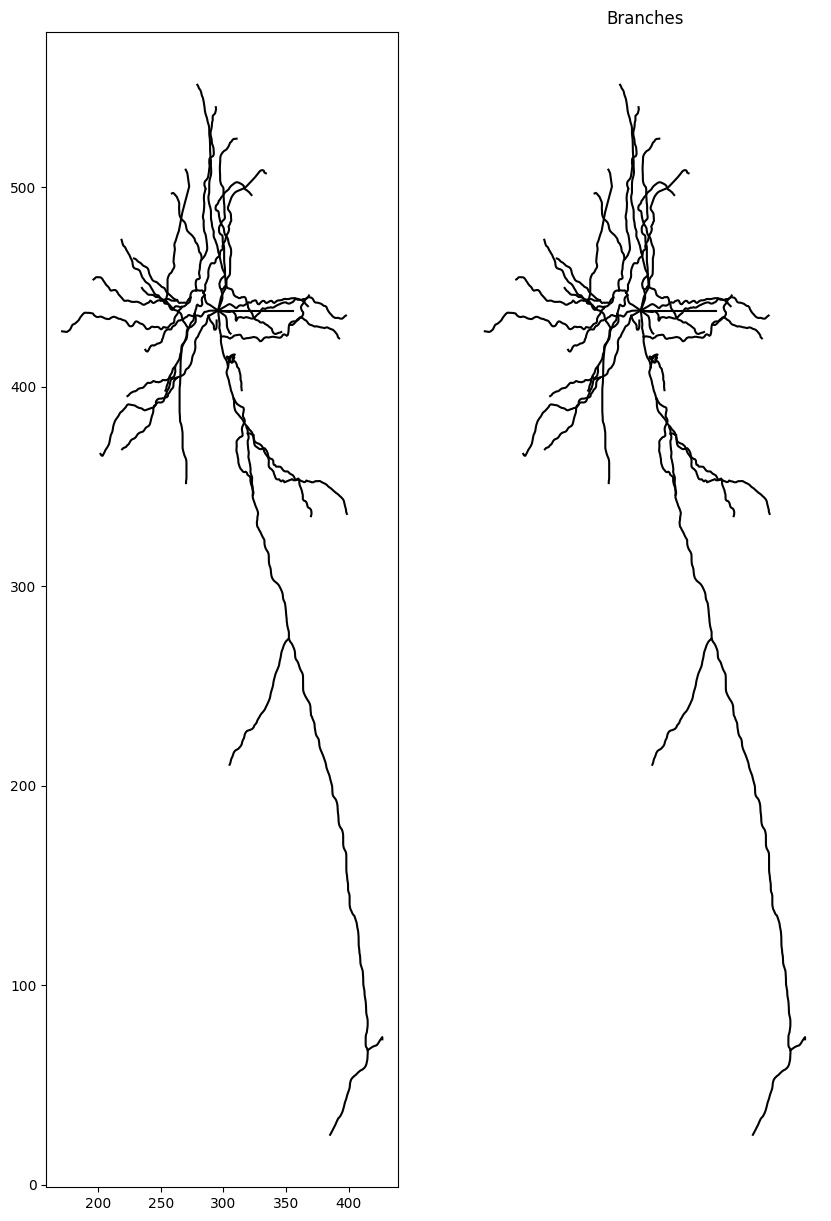

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
cell_orig.vis(ax=ax[0])
cell.vis(ax=ax[1])
# define colorwheel with 10 colors
# colors = plt.cm.tab10.colors
# for i, branch in enumerate(cell.branches):
#     branch.vis(ax=ax, col=colors[i % 10])
#cell.basal.vis(ax=ax, col='k')
plt.axis("off")
plt.title("Branches")
plt.show()





In [67]:
nseg_per_branch = 4
fname = '/Users/elena.westeinde/Code/jaxley_experiments/Allen_biophysical/Nr5a1_473862496/components/morphologies/reconstruction_noAxon.swc'
lcomp = 20 # from config file
max_branch_len = 20000
axon_ncomp = 2 # Allen biophysical model has 2 compartments for axon of 30 microns each

cell = read_swc_varComps(fname, lcomp, max_branch_len=2000.0, axon_ncomp=axon_ncomp, assign_groups=True)
print(cell.shape)

# load in csv file
BMTK_morphology = pd.read_csv('/Users/elena.westeinde/Code/jaxley_experiments/Allen_biophysical/cell_info.csv')

for idx, row in BMTK_morphology.iterrows():
    sec_name = row['section']
    sidx = sec_name.index(".")
    eidx = sec_name.index("(")
    branch = sec_name[sidx+1:eidx]
    BMTK_morphology.loc[idx, 'branch'] = branch

# get index of unique values in branch column
unique_branches = BMTK_morphology.drop_duplicates('branch').index
BMTK_branches = BMTK_morphology.iloc[unique_branches]
BMTK_branches.drop('section', axis=1, inplace=True)
BMTK_branches.reset_index(drop=True, inplace=True)

bmtk_soma_idx = BMTK_branches[BMTK_branches['branch'].str.contains('soma')].index
bmtk_basal_idx = BMTK_branches[BMTK_branches['branch'].str.contains('dend')].index
bmtk_apical_idx = BMTK_branches[BMTK_branches['branch'].str.contains('apic')].index
bmtk_axon_idx = BMTK_branches[BMTK_branches['branch'].str.contains('axon')].index

bmtk_soma_comps = BMTK_branches.iloc[bmtk_soma_idx]['nseg'].sum()
bmtk_apical_comps = BMTK_branches.iloc[bmtk_apical_idx]['nseg'].sum()
bmtk_basal_comps = BMTK_branches.iloc[bmtk_basal_idx]['nseg'].sum()
bmtk_axon_comps = BMTK_branches.iloc[bmtk_axon_idx]['nseg'].sum()

jax_soma = cell.soma.nodes
jax_apical = cell.apical.nodes
jax_axon = cell.axon.nodes
jax_basal = cell.basal.nodes

print('bmtk_soma_branches: ', bmtk_soma_idx.size, ' jax_soma_branches: ', max(cell.soma.nodes['local_branch_index']) + 1)
print('bmtk_apical_branches: ', bmtk_apical_idx.size, ' jax_apical_branches: ', max(cell.apical.nodes['local_branch_index']) + 1)
print('bmtk_basal_branches: ', bmtk_basal_idx.size, ' jax_basal_branches: ', max(cell.basal.nodes['local_branch_index']) + 1)
print('bmtk_axon_branches: ', bmtk_axon_idx.size, ' jax_axon_branches: ', max(cell.axon.nodes['local_branch_index']) + 1)

print('bmtk_soma_comps: ', bmtk_soma_comps, ' jax_soma_comps: ', jax_soma.shape[0])
print('bmtk_apical_comps: ', bmtk_apical_comps, ' jax_apical_comps: ', jax_apical.shape[0])
print('bmtk_basal_comps: ', bmtk_basal_comps, ' jax_basal_comps: ', jax_basal.shape[0])
print('bmtk_axon_comps: ', bmtk_axon_comps, ' jax_axon_comps: ', jax_axon.shape[0])

# BMTK axon: two branches, each with one compartment of 30 microns
# Jaxley axon: one branch with two compartments each of 30 microns
# might matter, might not matter, need to test


/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


(58, 155)
bmtk_soma_branches:  1  jax_soma_branches:  1
bmtk_apical_branches:  18  jax_apical_branches:  18
bmtk_basal_branches:  38  jax_basal_branches:  38
bmtk_axon_branches:  2  jax_axon_branches:  1
bmtk_soma_comps:  1  jax_soma_comps:  1
bmtk_apical_comps:  54  jax_apical_comps:  54
bmtk_basal_comps:  98  jax_basal_comps:  98
bmtk_axon_comps:  2  jax_axon_comps:  2


/var/folders/9r/hc37f5p166vcfrh22xz3qq2h0000gp/T/ipykernel_49558/4015621412.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMTK_branches.drop('section', axis=1, inplace=True)


In [68]:
def Repeat(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        k = i + 1
        for j in range(k, _size):
            if x[i] == x[j] and x[i] not in repeated:
                repeated.append(x[i])
    return repeated

t1 = cell.apical.nodes.index.to_list()
t2 = cell.basal.nodes.index.to_list()
t3 = t1 + t2

print (Repeat(t3))

# no duplicated indices in the apical and basal branch groups from cell_template used to set up groups for cell
t1 =  jax_apical.index.to_list()
t2 =  jax_basal.index.to_list()
t3 = t1 + t2

print (Repeat(t3))

# Duplicated compartment IDs in the apical and basal groups appear only if I change the number of branch segements after loading in the morphology

[]
[]


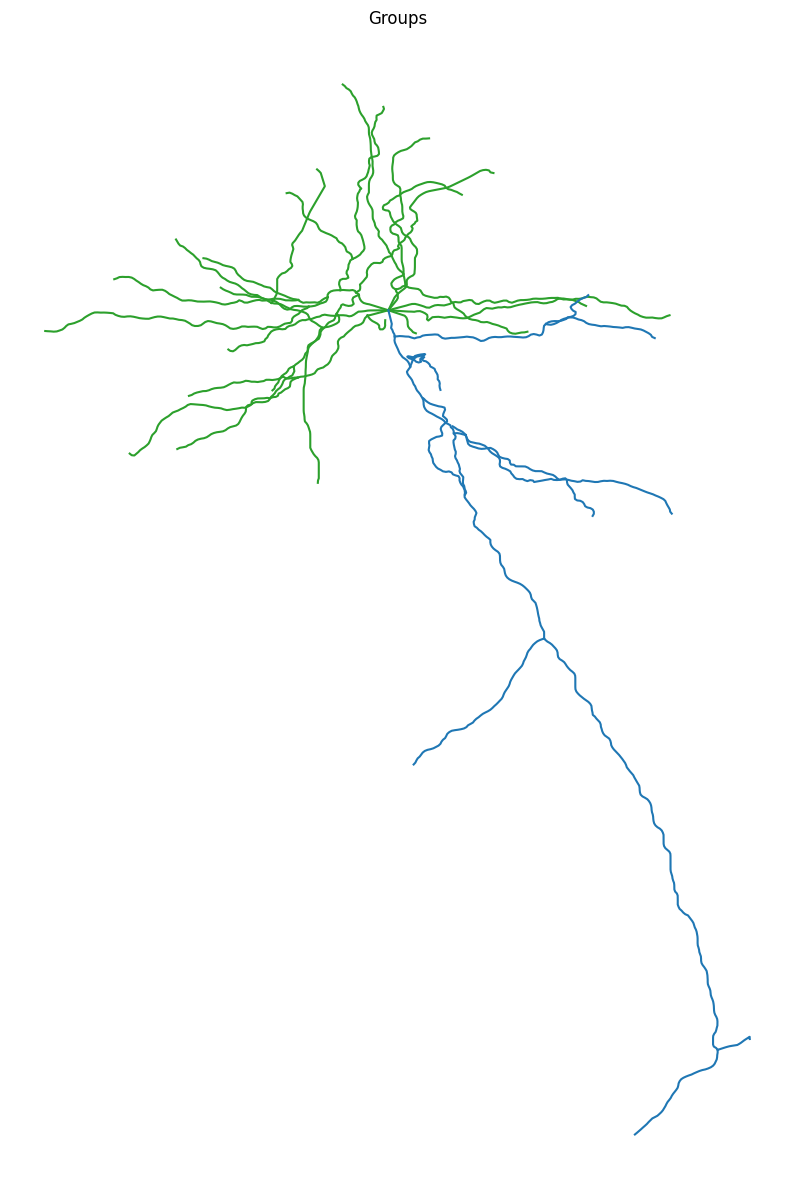

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, col=colors[2])
cell.apical.vis(ax=ax, col=colors[0])
cell.axon.vis(ax=ax, col=colors[3])
cell.soma.vis(ax=ax, col=colors[1])
plt.axis("off")
plt.title("Groups")
plt.show()

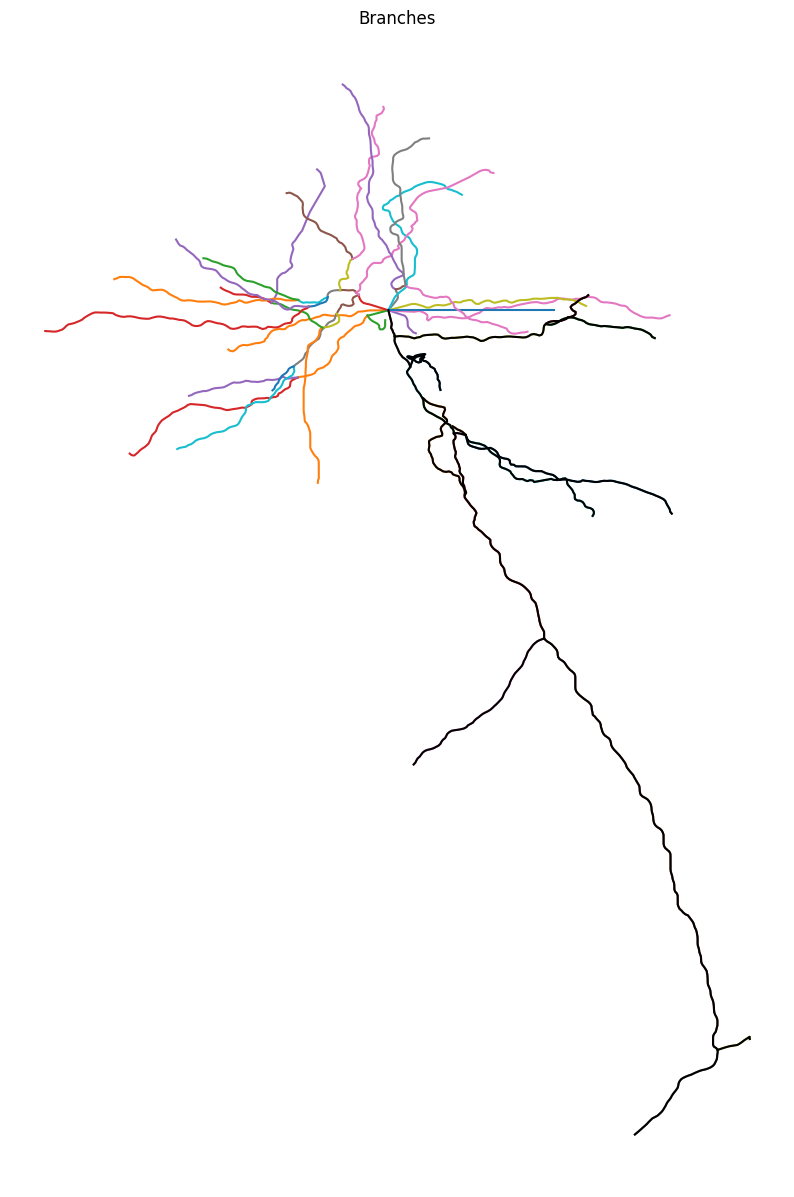

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i, branch in enumerate(cell.branches):
    branch.vis(ax=ax, col=colors[i % 10])
cell.apical.vis(ax=ax, col='k')
plt.axis("off")
plt.title("Branches")
plt.show()